In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as stats
from datetime import datetime

In [2]:
def stock_monte_carlo(start_price, days, mu, sigma):
    price_path = np.zeros(days)
    price_path[0] = start_price
    
    daily_returns = np.random.normal(mu, sigma, days - 1)
    
    for t in range(1, days):
        price_path[t] = price_path[t-1] * np.exp(daily_returns[t-1])
        
    return price_path

def backtest_monte_carlo(ticker, history_end_date, simulation_end_date, num_simulations, time_horizon, history_start_date: str = '1900-01-01'):
    history_data = yf.download(ticker, start = history_start_date, end=history_end_date)
    if history_data.empty:
        print(f"Error: No historical data found for {ticker} up to {history_end_date}.")
        return

    actual_data = yf.download(ticker, start=history_end_date, end=simulation_end_date)
    if actual_data.empty:
        print(f"Error: No actual data found for comparison between {history_end_date} and {simulation_end_date}.")
        return

    log_returns = np.log(1 + history_data['Close'].pct_change())
    start_price = history_data.iloc[-1]['Close']
    mu = log_returns.mean()
    sigma = log_returns.std()

    simulations = np.zeros(num_simulations)
    for run in range(num_simulations):
        price_path = np.zeros(time_horizon)
        price_path[0] = start_price
        daily_returns = np.random.normal(mu, sigma, time_horizon - 1)
        for t in range(1, time_horizon):
            price_path[t] = price_path[t-1] * np.exp(daily_returns[t-1])
        simulations[run] = price_path[-1]

    actual_price = actual_data['Close'].iloc[-1]
    if isinstance(actual_price, pd.Series):
        actual_price = actual_price.item()
    mean_final_price = simulations.mean()
    lower_bound = np.percentile(simulations, 2.5)
    upper_bound = np.percentile(simulations, 97.5)
    
    is_accurate = 'Yes' if lower_bound <= actual_price <= upper_bound else 'No'

    print("\n--- Backtesting Results ---")
    print(f"Simulated stock: {ticker}")
    print(f"Simulation Period: {history_end_date} to {simulation_end_date}")
    print(f"Actual End Price: ${actual_price:.2f}")
    print(f"Simulated Mean Final Price: ${mean_final_price:.2f}")
    print(f"95% Confidence Interval: [${lower_bound:.2f}, ${upper_bound:.2f}]")
    print(f"Did the actual price fall within the 95% CI? {is_accurate}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(simulations, bins=100, label='Simulated Prices')
    plt.axvline(actual_price, color='red', linestyle='dashed', linewidth=2, label=f'Actual End Price: ${actual_price:.2f}')
    plt.axvline(mean_final_price, color='green', linestyle='dashed', linewidth=2, label=f'Mean Simulated Price: ${mean_final_price:.2f}')
    plt.title('Monte Carlo Simulation Backtest', fontsize=16)
    plt.xlabel('Final Stock Price ($)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def sensitivity_analysis(ticker, end_date, num_simulations, time_horizon, volatility_multiplier):
    try:
        data = yf.download(ticker, start='2023-04-01', end=end_date)
        if data.empty:
            print(f"Error: No data found for ticker {ticker} up to {end_date}.")
            return
    except Exception as e:
        print(f"Error downloading data: {e}")
        return
        
    log_returns = np.log(1 + data['Close'].pct_change())
    start_price = float(data.iloc[-1]['Close'])
    mu = log_returns.mean()
    sigma = log_returns.std() * volatility_multiplier

    simulations = np.zeros(num_simulations)
    for run in range(num_simulations):
        price_path = np.zeros(time_horizon)
        price_path[0] = start_price
        daily_returns = np.random.normal(mu, sigma, time_horizon - 1)
        for t in range(1, time_horizon):
            price_path[t] = price_path[t-1] * np.exp(daily_returns[t-1])
        simulations[run] = price_path[-1]

    mean_final_price = simulations.mean()
    
    print(f"\n--- Sensitivity Analysis with Volatility Multiplier {volatility_multiplier:.2f} ---")
    print(f"Start Price: ${start_price:.2f}")
    print(f"Mean Final Price: ${mean_final_price:.2f}")

    plt.figure(figsize=(10, 6))
    plt.hist(simulations, bins=100)
    plt.title(f'Sensitivity Analysis: Volatility Multiplier {volatility_multiplier:.2f}', fontsize=16)
    plt.xlabel('Final Stock Price ($)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.axvline(start_price, color='red', linestyle='dashed', linewidth=2, label=f'Start Price: ${start_price:.2f}')
    plt.axvline(mean_final_price, color='green', linestyle='dashed', linewidth=2, label=f'Mean Simulated Price: ${mean_final_price:.2f}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
tickers = ['GOOG']
end_date = '2024-03-31'
data = yf.download(tickers, start='2023-04-01', end=end_date)

C:\Users\harsh\AppData\Local\Temp\ipykernel_63132\2606280382.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2023-04-01', end=end_date)
[*********************100%***********************]  1 of 1 completed


In [4]:
goog_data = data['Close']['GOOG']

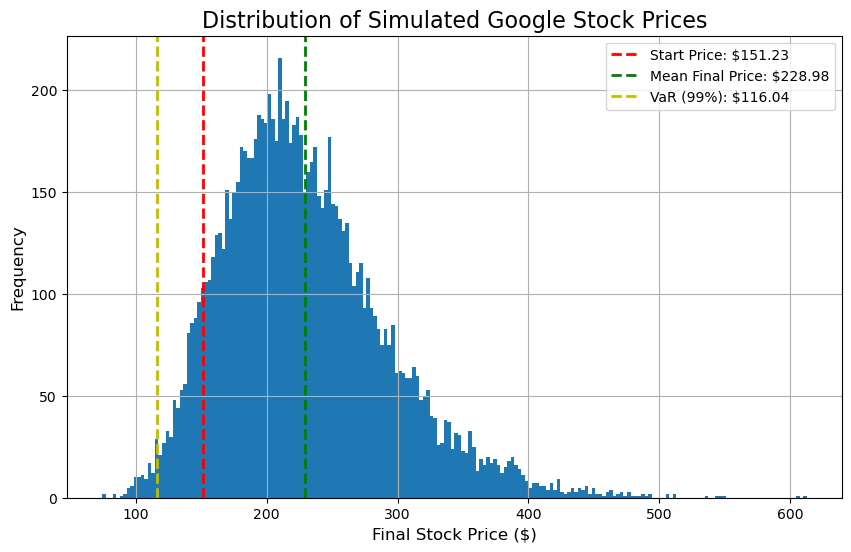

--- Simulation Results ---
Start Price: $151.23
Mean Final Price after 252 days: $228.98
Value at Risk (99%): $116.04


In [5]:
log_returns = np.log(1 + goog_data.pct_change())
mu = log_returns.mean()
sigma = log_returns.std()
start_price = goog_data.iloc[-1]
num_simulations = 10000
time_horizon = 252

simulations = np.zeros(num_simulations)
for run in range(num_simulations):
    simulations[run] = stock_monte_carlo(start_price, time_horizon, mu, sigma)[-1]

mean_final_price = simulations.mean()
var_99 = np.percentile(simulations, 1)

plt.figure(figsize=(10, 6))
plt.hist(simulations, bins=200)
plt.title('Distribution of Simulated Google Stock Prices', fontsize=16)
plt.xlabel('Final Stock Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(start_price, color='r', linestyle='dashed', linewidth=2, label=f'Start Price: ${start_price:.2f}')
plt.axvline(mean_final_price, color='g', linestyle='dashed', linewidth=2, label=f'Mean Final Price: ${mean_final_price:.2f}')
plt.axvline(var_99, color='y', linestyle='dashed', linewidth=2, label=f'VaR (99%): ${var_99:.2f}')
plt.legend()
plt.grid(True)
plt.show()

print(f"--- Simulation Results ---")
print(f"Start Price: ${start_price:.2f}")
print(f"Mean Final Price after {time_horizon} days: ${mean_final_price:.2f}")
print(f"Value at Risk (99%): ${var_99:.2f}")


C:\Users\harsh\AppData\Local\Temp\ipykernel_63132\515277306.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  history_data = yf.download(ticker, start = history_start_date, end=history_end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\harsh\AppData\Local\Temp\ipykernel_63132\515277306.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  actual_data = yf.download(ticker, start=history_end_date, end=simulation_end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\harsh\AppData\Local\Temp\ipykernel_63132\515277306.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_path[0] = start_price



--- Backtesting Results ---
Simulated stock: GOOG
Simulation Period: 2023-04-01 to 2024-03-31
Actual End Price: $151.23
Simulated Mean Final Price: $107.02
95% Confidence Interval: [$52.92, $194.02]
Did the actual price fall within the 95% CI? Yes


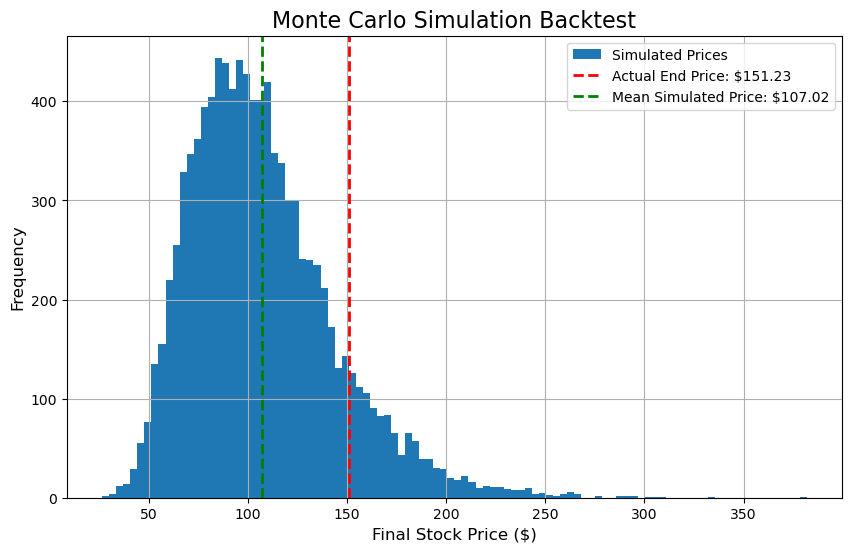

In [6]:
backtest_monte_carlo('GOOG', '2023-04-01', '2024-03-31', num_simulations=10000, time_horizon=252,history_start_date='2021-04-01')


C:\Users\harsh\AppData\Local\Temp\ipykernel_63132\515277306.py:67: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2023-04-01', end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\harsh\AppData\Local\Temp\ipykernel_63132\515277306.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  start_price = float(data.iloc[-1]['Close'])



--- Sensitivity Analysis with Volatility Multiplier 1.10 ---
Start Price: $151.23
Mean Final Price: $232.09


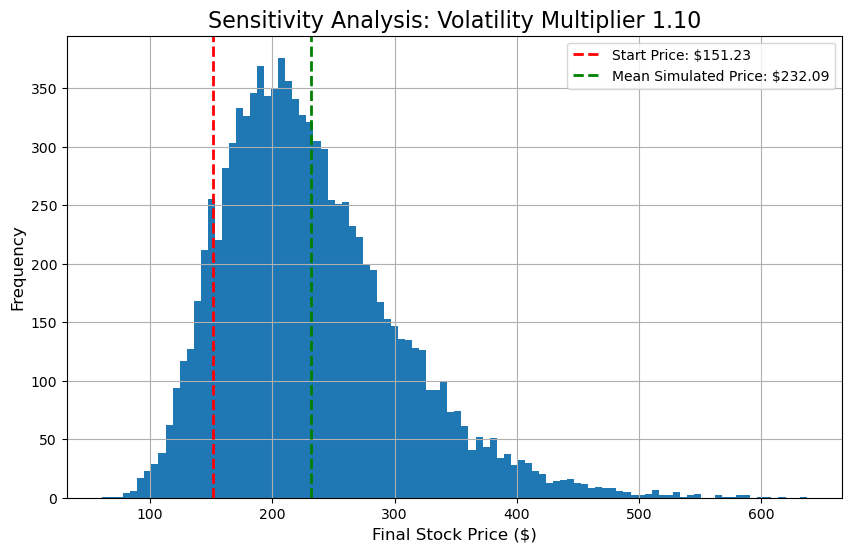

In [7]:
sensitivity_analysis('GOOG', '2024-03-31', num_simulations=10000, time_horizon=252, volatility_multiplier=1.1)